### Stock Market Prediction And Forecasting Using Stacked LSTM - Intraday


In [1]:
### Keras and Tensorflow >2.0

import os
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf
from datetime import datetime
from sklearn.metrics import mean_squared_error
import mplfinance as mpf


/Users/sharselv/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
tickerName = "GOKULAGRO.NS"
tickerRange = "6mo"
tickerInterval = "60m"
label_name = "Close"
window_size = 50
epochs = 100
batch_size = 64
train_test_split = 0.8
#actually hours
prediction_days = 5
feature_size = 4
modelFileName = f"../../Models/lstm_4_features_{tickerName}_range_mo-{tickerRange}_int_min-{tickerInterval}_{label_name}_{window_size}_{epochs}_{batch_size}_prediction_hours_{prediction_days}.keras"
columnList = ['Open', 'High', 'Low', 'Close']



In [3]:
def getModelFileName(ticker, range, interval, window_size, epochs, batch_size, prediction_days, feature_size):
    modelFileName = f"../../Models/lstm_4_features_{ticker}_range_mo-{range}_int_min-{interval}_{window_size}_{epochs}_{batch_size}_prediction_hours_{prediction_days}_feature_size_{feature_size}.keras"
    return modelFileName

def plot_candlestick(data, label_name, tickerRange, tickerInterval, dirPath = "../../Results/market_prediction_plots/"):
    # Convert index to DatetimeIndex
    today =  datetime.today().strftime('%Y%m%d%H')
    fileName = f"{label_name}-{today}-int_{tickerInterval}-range_{tickerRange}.png"
    filePath = dirPath + fileName
    data.index = pd.to_datetime(data.index)
    mpf.plot(data, type='candle', style='charles', figsize=(12, 8), title=label_name, mav=5)
    mpf.plot(data, type='candle', style='charles', figsize=(12, 8), title=label_name, mav=5, savefig=filePath)

def get_data(tickerName, tickerRange, tickerInterval, dirPath = "../../Data/market_prediction/"):
    today =  datetime.today().strftime('%Y%m%d%H')
    fileName = f"{tickerName}-{today}-int_{tickerInterval}-range_{tickerRange}.csv"
    filePath = dirPath + fileName
    if os.path.exists(filePath):
        df = pd.read_csv(filePath, index_col=0)
    else:
        df = yf.Ticker(tickerName)
        df = df.history(period=tickerRange, interval=tickerInterval)
        df.to_csv(filePath)
    return df
    
def reset_index_and_plot(df, columnList):
    df1=df.reset_index()[columnList]
    df2 = df[columnList]
    return df1, df2

def convertToArrayAndScale(df1):
    scaler=MinMaxScaler(feature_range=(0,1))
    df1=scaler.fit_transform(np.array(df1).reshape(-1,feature_size))
    print(f"df1.shape: {df1.shape}")
    return df1, scaler

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1, dataYCount=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-dataYCount):
		a = dataset[i:(i+time_step)]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step])
	return np.array(dataX), np.array(dataY)

##splitting dataset into train and test split
def split_data(df1, split_ratio = train_test_split):
    training_size=int(len(df1)*split_ratio)
    test_size=len(df1)-training_size
    train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:]
    return train_data, test_data

# reshape input to be [samples, time steps, features] which is required for LSTM
def reshape_data(X_train, X_test, feature_size):
    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , feature_size)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , feature_size)
    return X_train, X_test

def create_model_if_not_exists(modelFileName, X_train, y_train, X_test, ytest, epochs, batch_size):
    model = None
    if(os.path.exists(modelFileName)):
        model = keras.models.load_model(modelFileName)
        print("Loaded saved model")
    else:
        model=Sequential()
        model.add(LSTM(200,return_sequences=True,input_shape=(window_size,feature_size)))
        model.add(LSTM(100,return_sequences=True))
        model.add(LSTM(50))
        model.add(Dense(feature_size))
        model.compile(loss='mean_squared_error',optimizer='adam')
        model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=epochs,batch_size=batch_size,verbose=1)
        model.save(modelFileName)
    return model

#Comparing the predictions with y_test and adding to bins. Y_test is the actual values and test_predict is the predicted values. y_test has values of the next 10 days.
def compare_predictions(y, predictions):
    avg_differences, max_deviations = compare_arrays(y, predictions)
    #convert to pandas series and plot bins using hist
    avg_differences = pd.Series(max_deviations)
    avg_differences.hist(bins=10)


def compare_arrays(y, predictions):
    # Calculate absolute differences between each cell
    differences = np.abs(y - predictions)
    
    # Calculate average difference for each row
    avg_differences = np.mean(differences, axis=1)
    
    # Calculate maximum deviation from the average difference for each row
    max_deviations = np.max(np.abs(differences - avg_differences[:, np.newaxis]), axis=1)
    
    return avg_differences, max_deviations

#convert numpy arrays to pandas series
def convert_to_df(arr):
    return pd.DataFrame(arr, columns=columnList)

#get predictions for the next 10 days
def get_predictions(model, data, window_size, prediction_days=10):
    predictions = []
    for i in range(prediction_days):
        last_window = data[-window_size:]
        last_window = last_window.reshape((1, window_size, feature_size))
        prediction = model.predict(last_window)
        predictions.append(prediction)
        data = np.concatenate((data, prediction))
    return data, data[-prediction_days:]


In [4]:
def getIntradayPredictionsForSingleTicker(ticker, range, interval, label_name, window_size, epochs, batch_size, prediction_days, feature_size):
    df = get_data(ticker, range, interval)
    df1, df2 = reset_index_and_plot(df, columnList)
    df1, scaler = convertToArrayAndScale(df1)
    train_data, test_data = split_data(df1)
    X_train, y_train = create_dataset(train_data, window_size, prediction_days)
    X_test, ytest = create_dataset(test_data, window_size, prediction_days)

    X_train, X_test = reshape_data(X_train, X_test, feature_size)
    modelName = getModelFileName(ticker, range, interval, window_size, epochs, batch_size, prediction_days, feature_size)
    model = create_model_if_not_exists(modelName, X_train, y_train, X_test, ytest, epochs, batch_size)
    ### Lets Do the prediction and check performance metrics
    train_predict=model.predict(X_train)
    test_predict=model.predict(X_test)
    ##Transformback to original form
    train_predict=scaler.inverse_transform(train_predict)
    test_predict=scaler.inverse_transform(test_predict)
    ytest_inv = scaler.inverse_transform(ytest)
    #convert test_predict and ytest_inv to dataframe same as df2
    test_predict_df = convert_to_df(test_predict)
    ytest_inv_df = convert_to_df(ytest_inv)


    #use plot_candlestick to plot the candlestick chart for the test_predict_df and ytest_inv_df
    plot_candlestick(test_predict_df, f"Test data pred: {label_name}", range, interval)
    plot_candlestick(ytest_inv_df, f"Test data actuals: {label_name}", range, interval)


    predictions = get_predictions(model, df1[-window_size:], window_size, prediction_days)
    futurePredArray = scaler.inverse_transform(predictions[0])
    futurePredDf = convert_to_df(futurePredArray)
    plot_candlestick(convert_to_df(df2[-50:]), f"Current trend: {label_name}", range, interval)
    plot_candlestick(futurePredDf, f"Predicted trend: {label_name}", range, interval)

df1.shape: (833, 4)
Loaded saved model
4/4 [==============================] - 0s 21ms/step


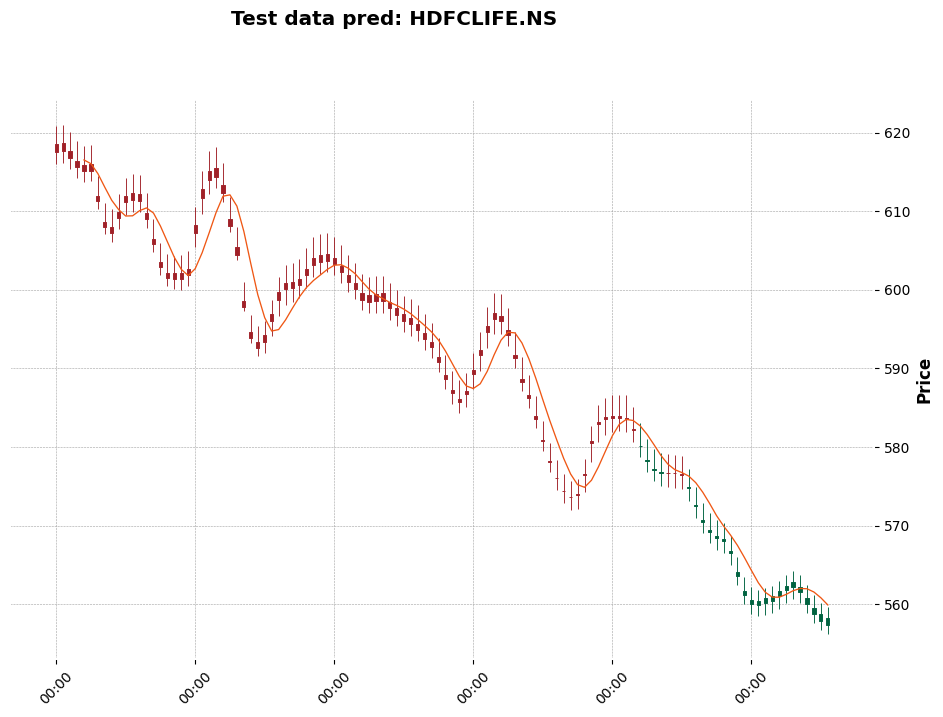

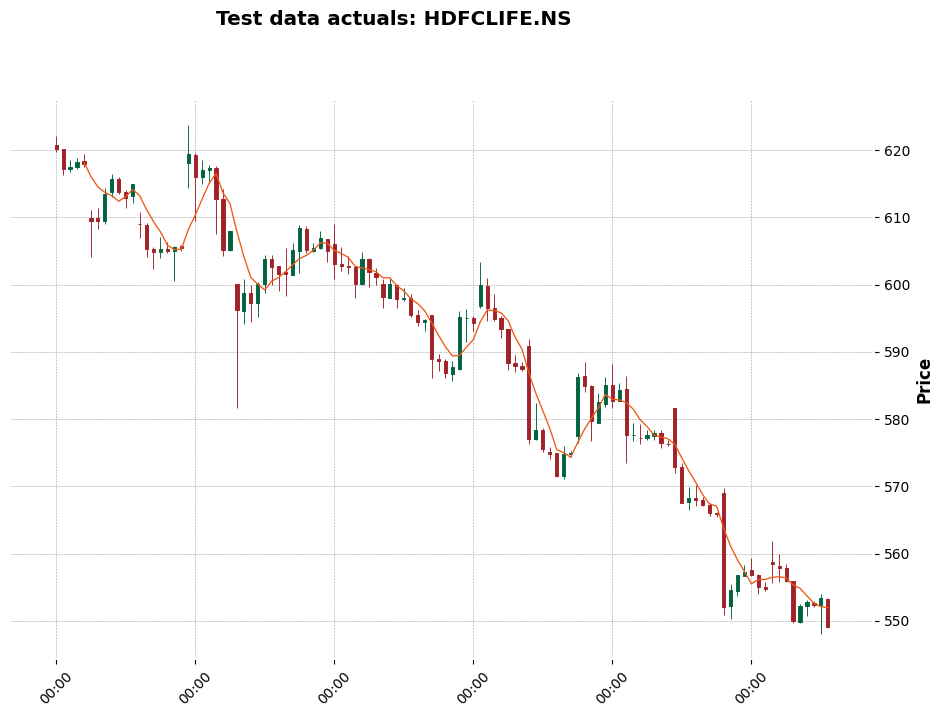

1/1 [==============================] - 0s 18ms/step


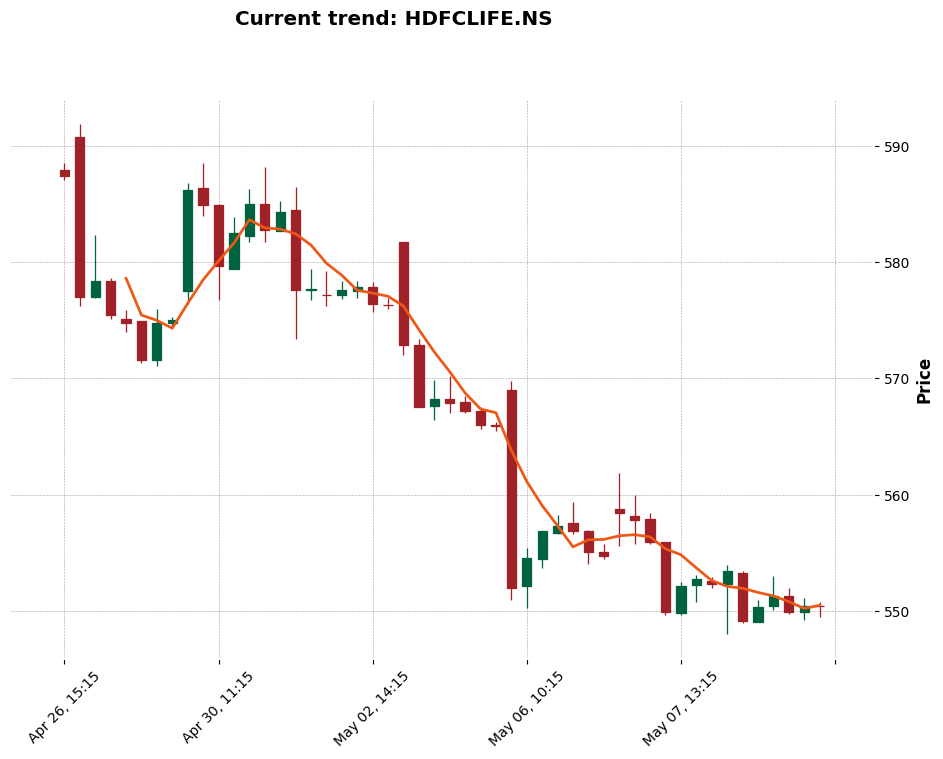

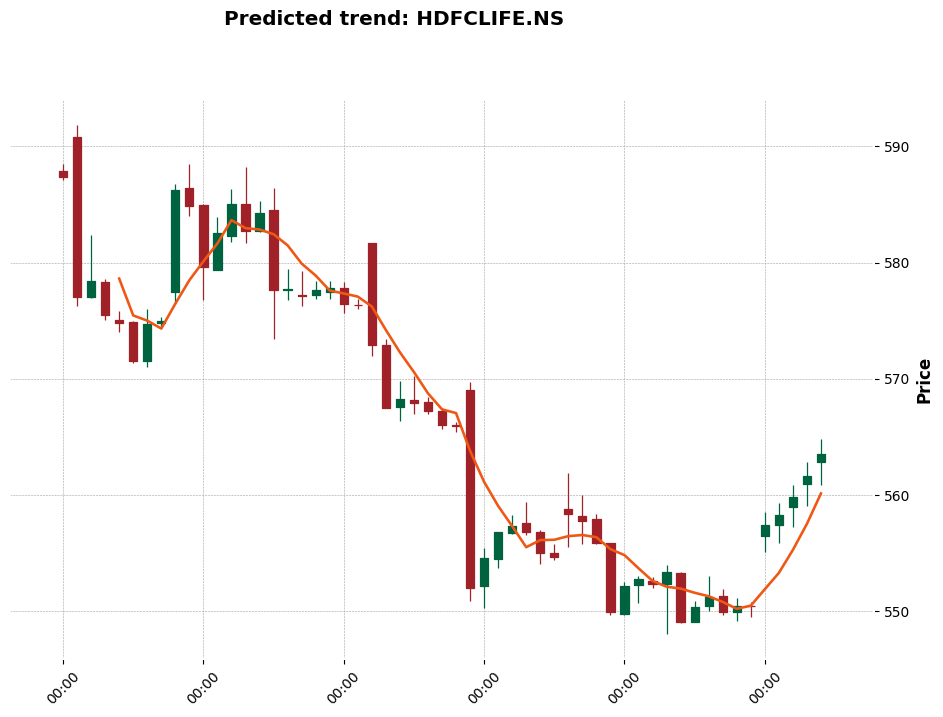

df1.shape: (833, 4)
Loaded saved model
4/4 [==============================] - 0s 19ms/step


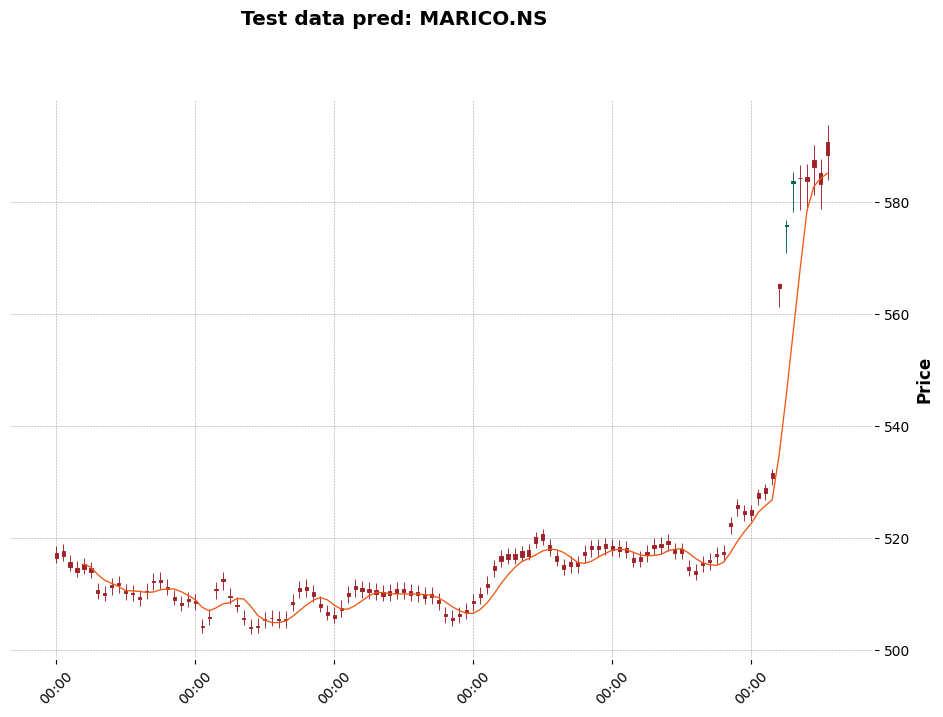

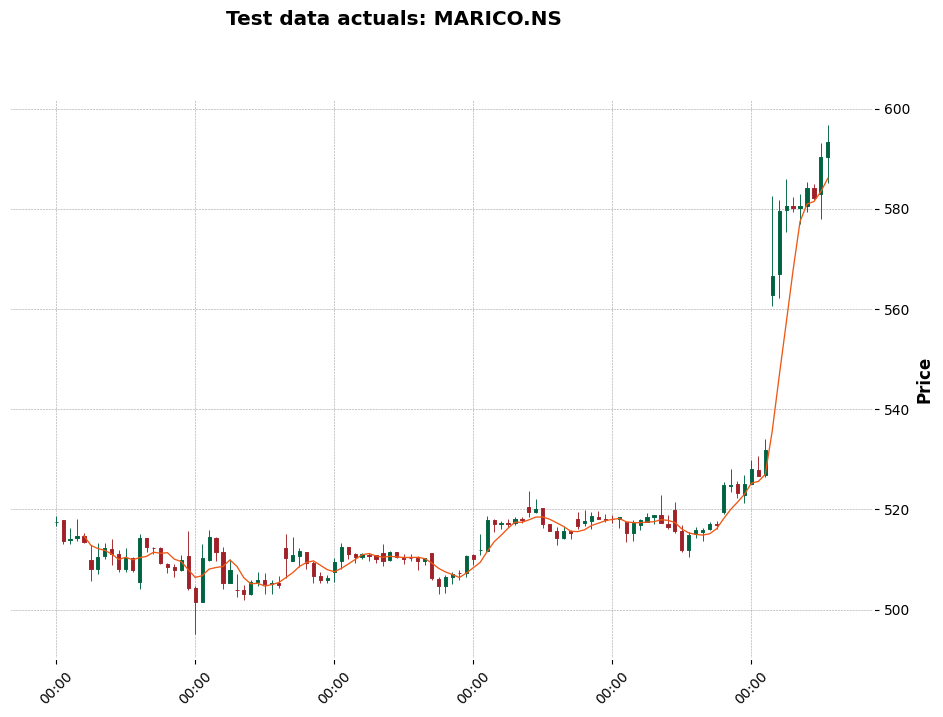

1/1 [==============================] - 0s 18ms/step


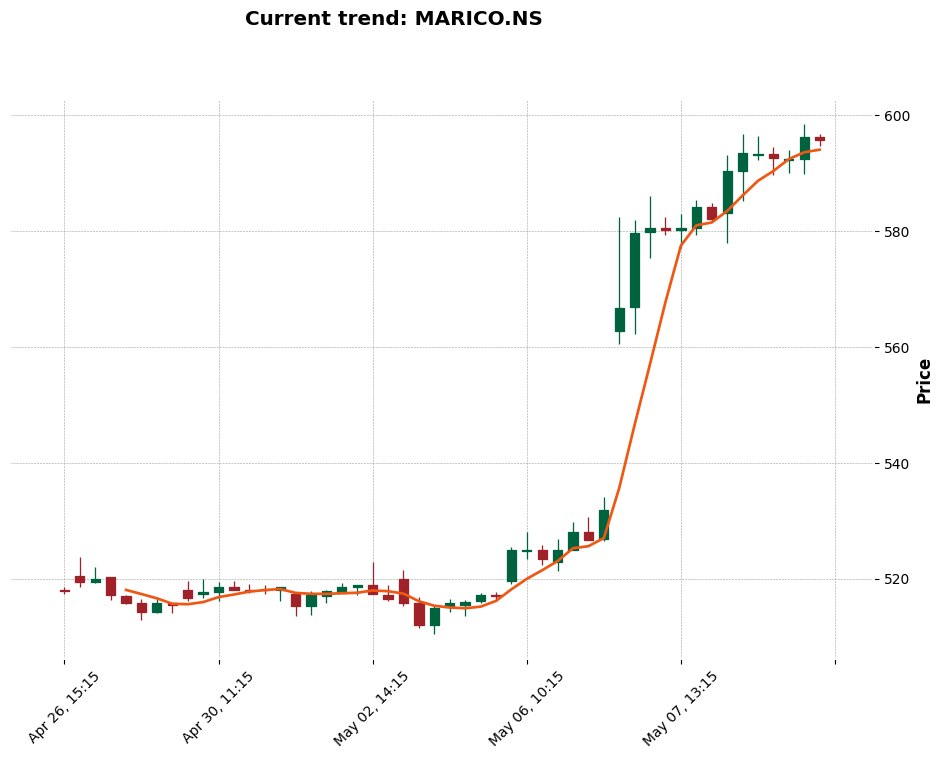

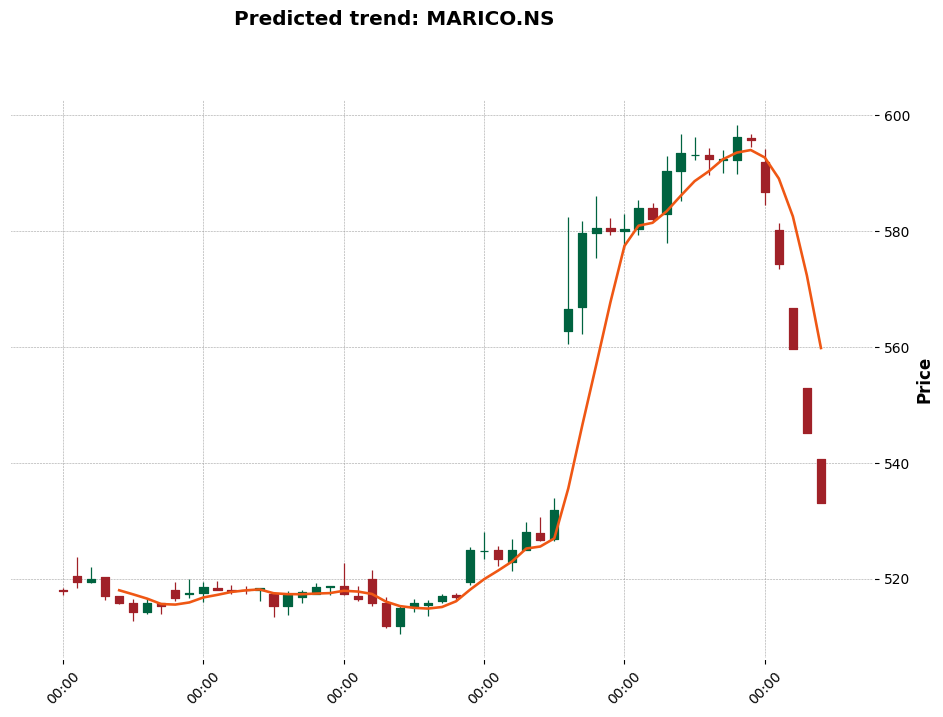

df1.shape: (833, 4)
Loaded saved model
4/4 [==============================] - 0s 19ms/step


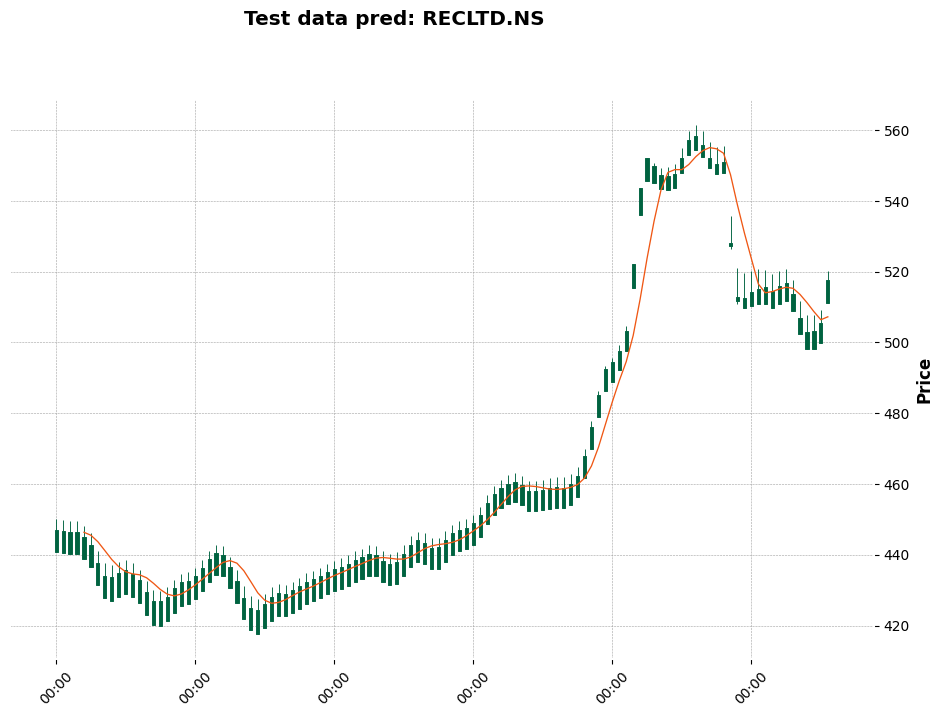

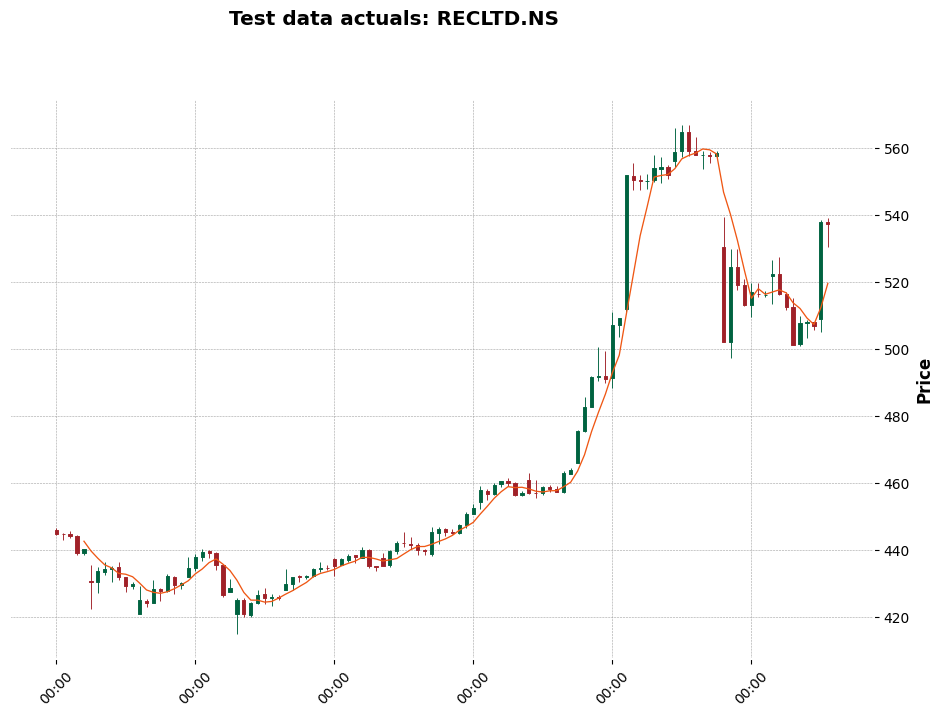

1/1 [==============================] - 0s 20ms/step


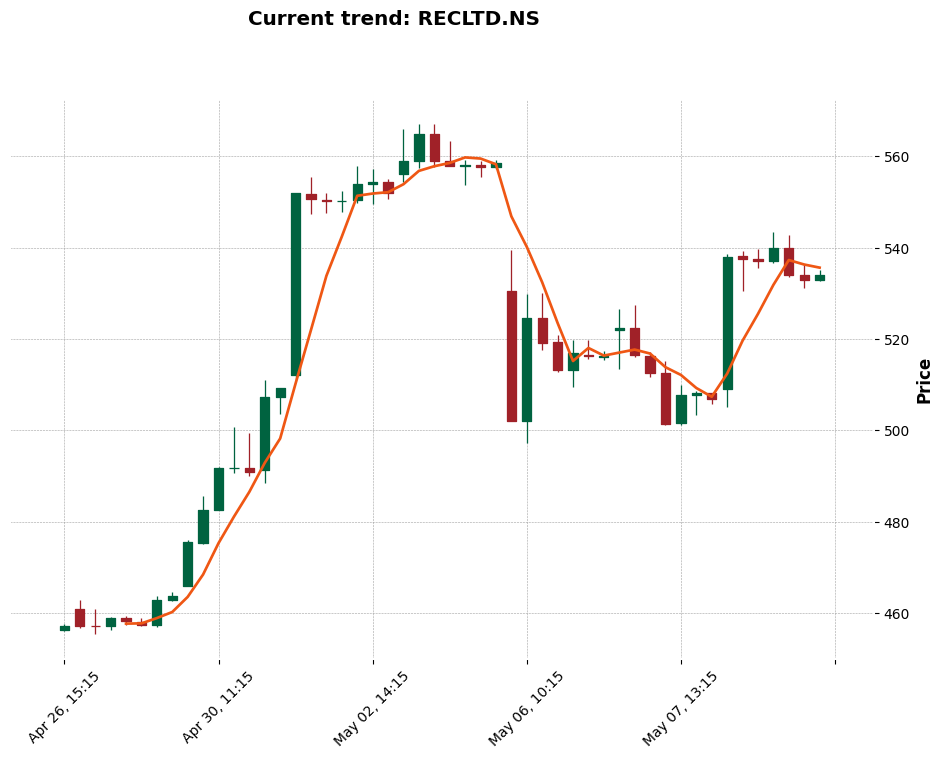

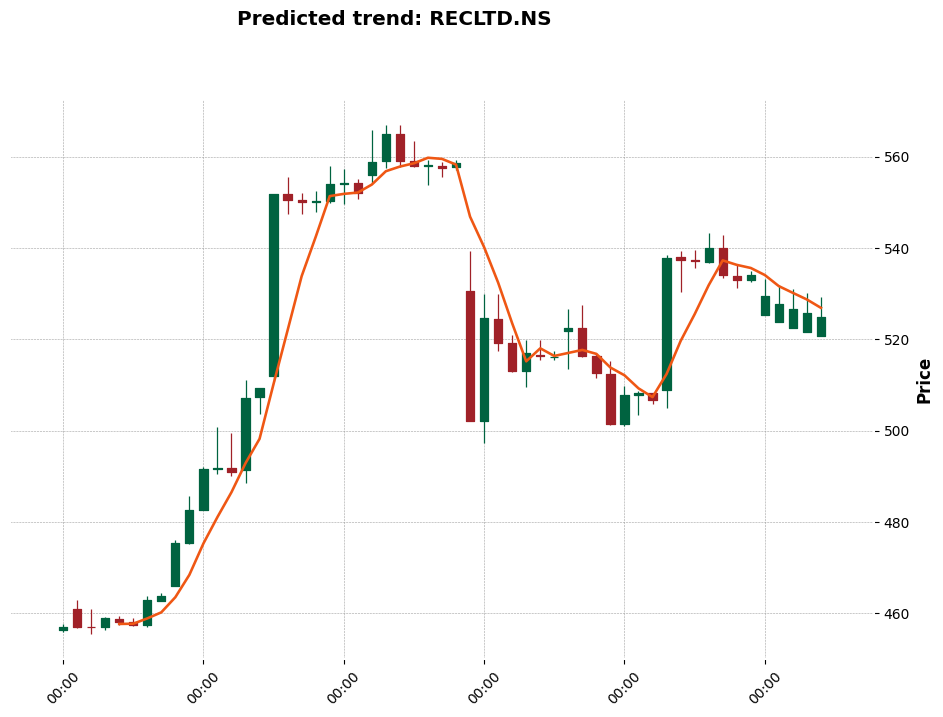

df1.shape: (833, 4)
Loaded saved model
4/4 [==============================] - 0s 21ms/step


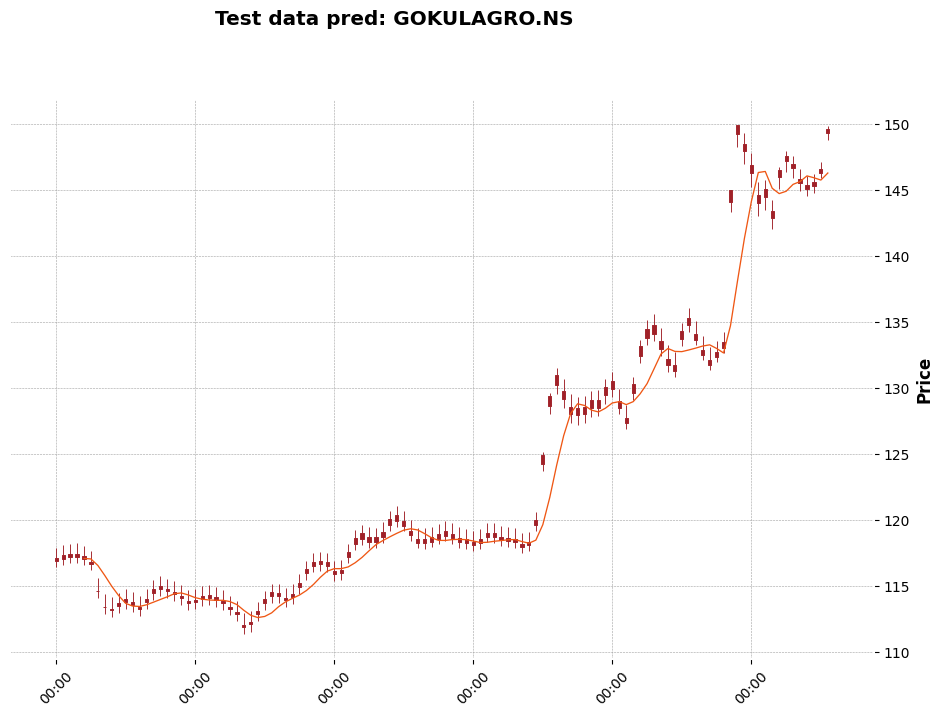

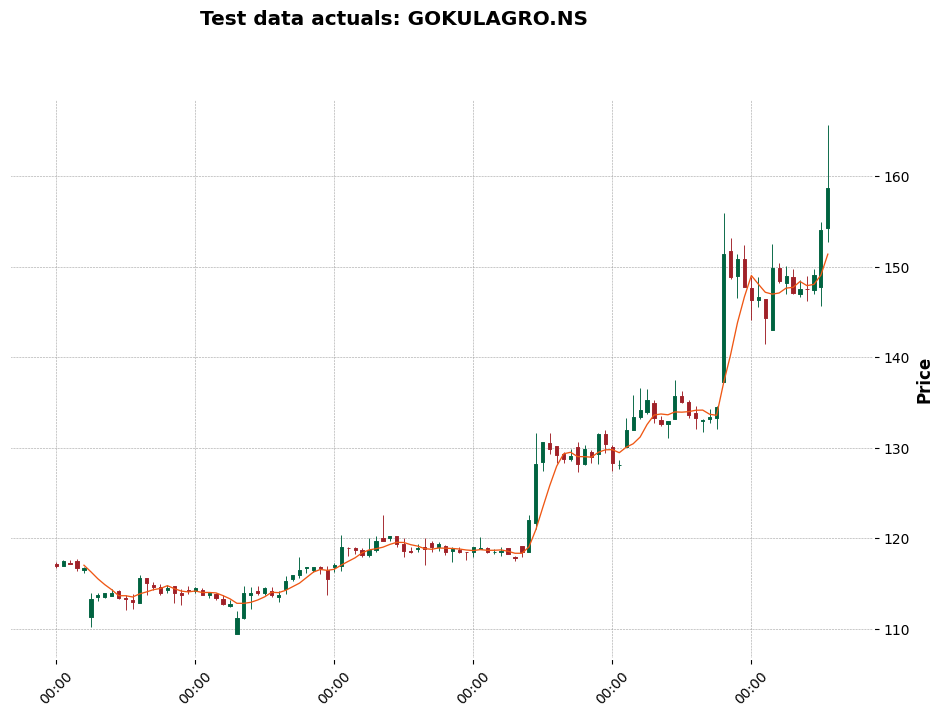

1/1 [==============================] - 0s 17ms/step


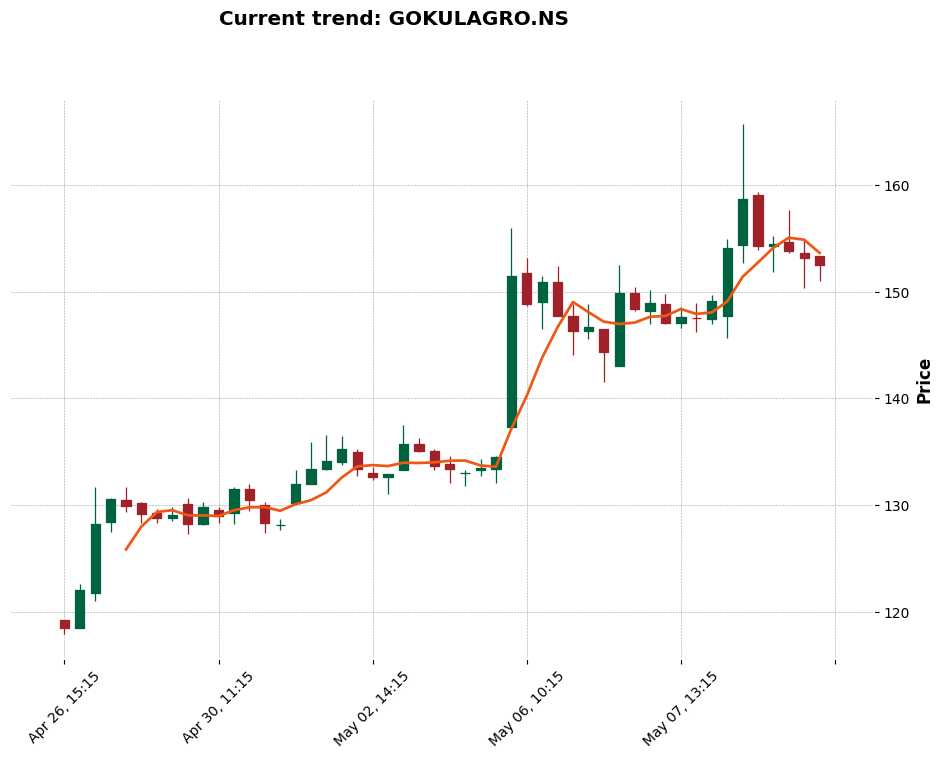

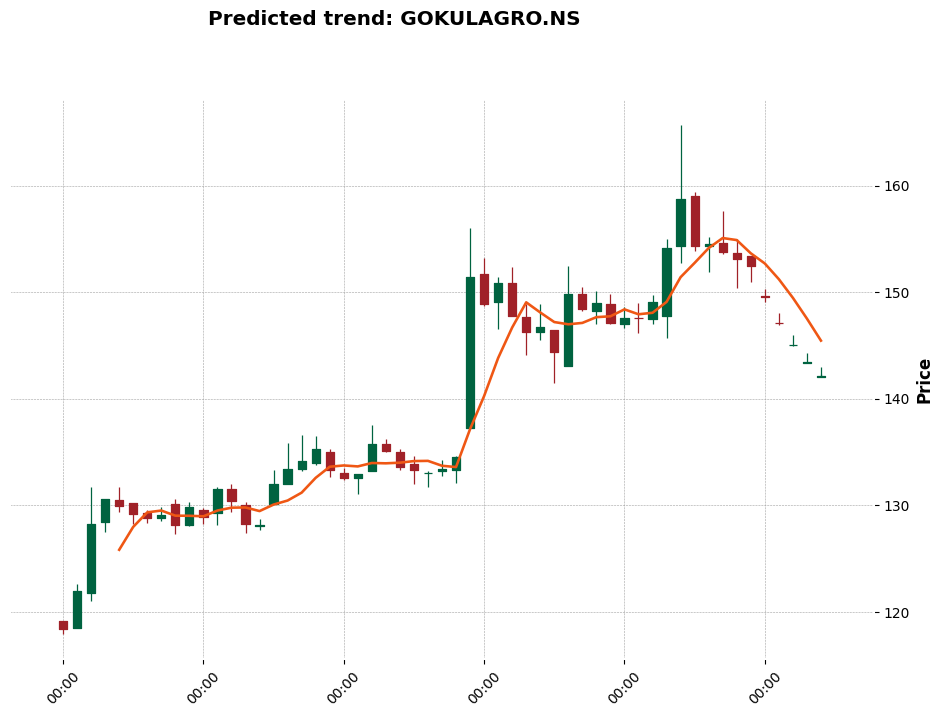

df1.shape: (833, 4)
Loaded saved model
4/4 [==============================] - 0s 21ms/step


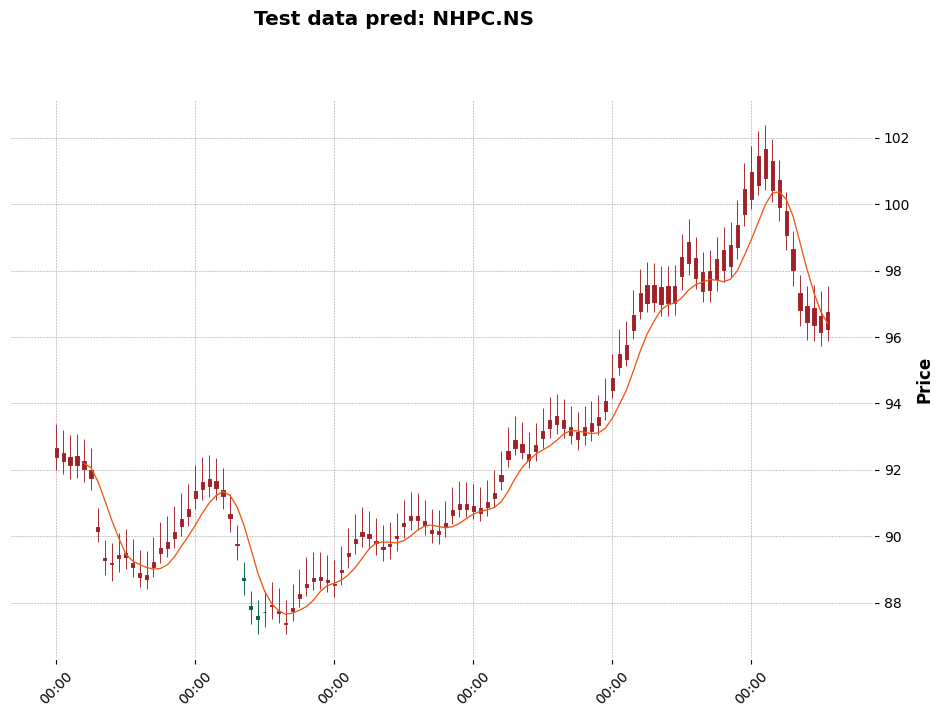

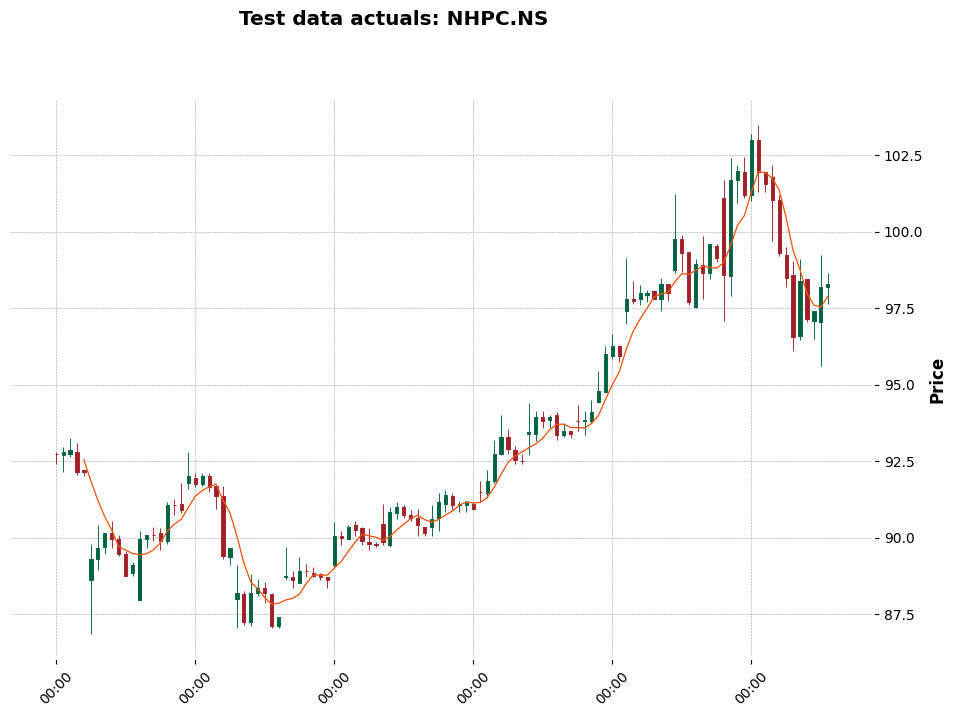

1/1 [==============================] - 0s 19ms/step


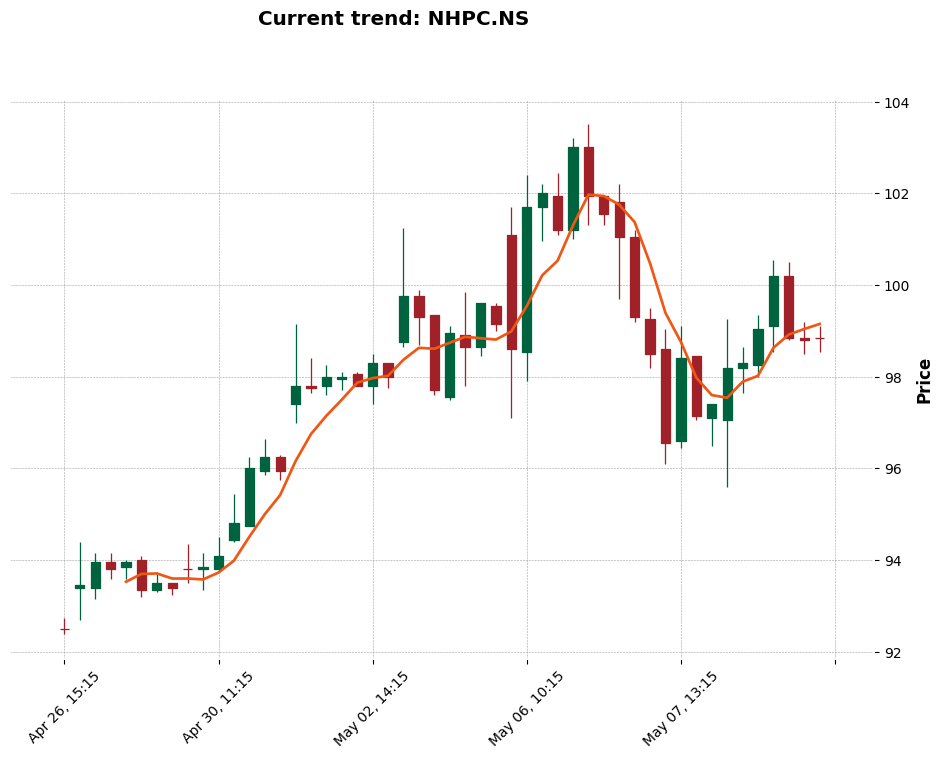

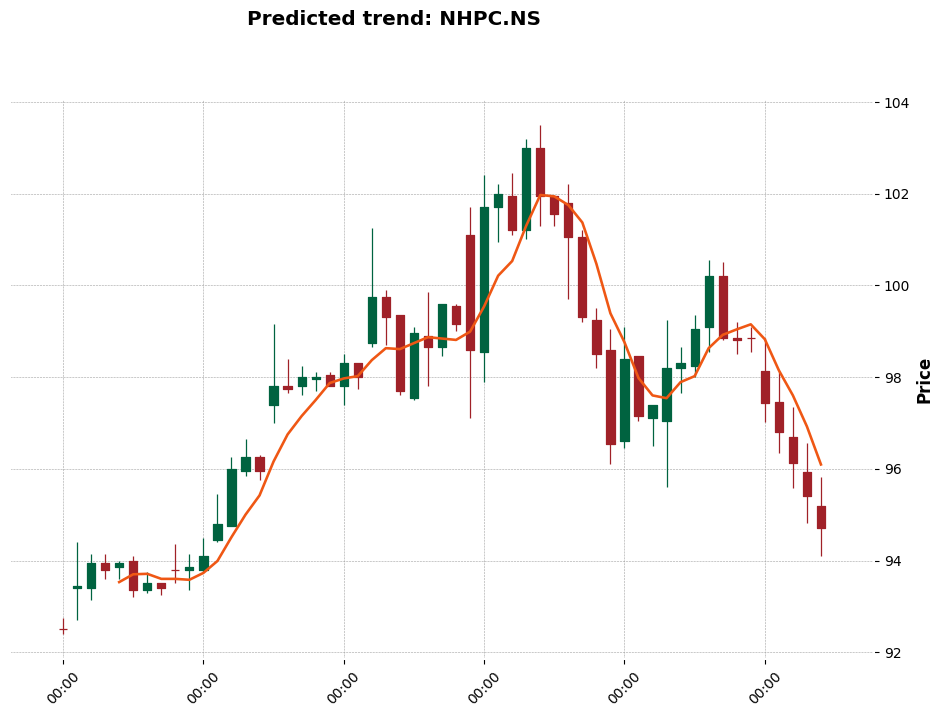

In [5]:
tickerListForDay = ["BAJFINANCE.NS", "HDFCLIFE.NS", "AUBANK.NS", "MARICO.NS", "RECLTD.NS", "GOKULAGRO.NS", "ASIANPAINT.NS"]
tickerListForDay = [ "HDFCLIFE.NS", "MARICO.NS", "RECLTD.NS", "GOKULAGRO.NS", "NHPC.NS"]
for ticker in tickerListForDay:
    tickerName = ticker
    getIntradayPredictionsForSingleTicker(ticker, tickerRange, tickerInterval, ticker, window_size, epochs, batch_size, prediction_days, feature_size)
